**1. What are the advantages of a CNN over a fully connected DNN for image classification?**

Convolutional layers have *partially connected* neurons, so in large images, the number of parameters is much more manageable. Also, in each feature map in a conv layer, all the neurons share the same weights and bias terms, meaning that a) there is way fewer parameters and b) if the network learns how to detect a certain feature, it will be able to detect that feature over the whole image, unlike a DNN where it has to learn to detect that same feature multiple times.

**2. Consider a CNN composed of three convolutional layers, each with 3x3 kernels, a stride of 2, and SAME padding. The lowest layer outputs 100 feature maps, the middle one outputs 200, and the top one outputs 400. The input images are RGB images of 200x300 pixels. What is the total number of parameters in the CNN? If we are using 32-bit floats, at least how much RAM will this network require when making a prediction for a single instance? What about when training on a mini-batch of 50 images?**

The total number of parameters per layer would be (kernel_area x num_channels + 1 (for bias)) x num_filters. Thus, we have

( (3x3x3+1)  x 100 ) + ( (3x3x3+1) x 200 ) + ( (3x3x3+1) x 400 ) = 2800 + 5600 + 11200 = 19,600 total parameters.

If we are inferencing on a single instance, we only need at maximum, enough RAM to hold the largest two consecutive layers in memory. Since we have strides of 2 in all our layers, that means that the first conv has (100x150x100)=1,500,000 neurons, then the second would has (50x75x200)=3,000,000 neurons, then the last has (25x38x400)=6,000,000 neurons, and each neuron has 3^3=27 inputs, so when training on a mini-batch of 50 images, you would need 27x(1,500,000+3,000,000+6,000,000)x32x50 bits = 56,700 Mb. 

**3. If your GPU runs out of memory while training a CNN, what are five things you could try to solve the problem?**

- Decrease the batch size

- Use a stride to decrease dimensionality.

- Use less layers.

- Use a pooling layer.

- Use 16-bit floats rather than 32-bit.

**4. Why would you want to add a max pooling layer rather than a convolutional layer with the same stride?**

While convolutional layers with a stride > 1 will be able to output smaller images than their inputs, they still add a lot of complexity. There are parameters based on the kernel size, the number of channels, and the number of feature maps. A pooling layer will shrink the image the same way, but it doesn't have any weight values and thus is not trainable. Pooling layers are very useful for removing complexity from the network, and thus reducing the possibility of overfitting.

**5. When would you want to add a local response normalization layer?**

If you want to increase the generalizability of your network, adding local response normalization is a good idea because it will encourage each layer to find a range of feature maps that are very different from one another.

**6. Can you name the main innovations in AlexNet compared to LeNet-5? What about the main innovations in GoogLeNet and ResNet?**

The main innovation of AlexNet compared to LeNet-5 was the fact that it was much deeper than LeNet. It also stacked multiple Conv layers in succession, and AlexNet used local response normalization.

The main innovation of ResNet over GoogLeNet was the introduction of skip connections.

**7. Build your own CNN and try to achieve the highest possible accuracy on MNIST.**

In [2]:
# What I want to implement in this CNN
# 1. Data augmentation
# 2. Not too large, about the size of AlexNet
# 3. Some regularization techniques
# 4. *Maybe* implementing local response regularization

import tensorflow as tf

In [38]:
img_input = tf.keras.layers.Input((28,28,1))
conv1 = tf.keras.layers.Conv2D(5, 3, strides=2, padding='SAME', 
                               activation=tf.keras.activations.elu,
                               kernel_regularizer=tf.keras.regularizers.l2(l=0.02))(img_input)
batch_norm_a = tf.keras.layers.BatchNormalization()(conv1)
pool2 = tf.keras.layers.MaxPool2D(2)(batch_norm_a)
conv3 = tf.keras.layers.Conv2D(10, 3, strides=2, padding='SAME',
                               activation=tf.keras.activations.elu,
                               kernel_regularizer=tf.keras.regularizers.l2(l=0.02))(pool2)
batch_norm_b = tf.keras.layers.BatchNormalization()(conv3)
flatten4 = tf.keras.layers.Flatten()(batch_norm_b)
dense5 = tf.keras.layers.Dense(50, activation=tf.keras.activations.elu)(flatten4)
dropout6 = tf.keras.layers.Dropout(.5)(dense5)
dense7 = tf.keras.layers.Dense(10, activation='softmax')(dropout6)

In [39]:
cnn = tf.keras.models.Model(inputs=[img_input], outputs=[dense7])
cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
cnn.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 5)         50        
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 5)         20        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 5)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 10)          460       
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 10)          40        
_________________________________________________________________
flatten_3 (Flatten)          (None, 160)               0   

In [46]:
# Load in MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((-1,28,28,1))
x_test = x_test.reshape((-1,28,28,1));
x_test = x_test/255.

In [59]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_std_normalization=True, featurewise_center=True,
    rotation_range=20, shear_range=3,
    rescale=1/255.
)

In [43]:
datagen.fit(x_train)

In [44]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)
tensorboard = tf.keras.callbacks.TensorBoard(histogram_freq=1)

In [47]:
cnn.fit(datagen.flow(x_train, y_train, batch_size=32), validation_data=(x_test, y_test), 
        callbacks=[early_stop, tensorboard], epochs=15)

Epoch 1/15
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4814 - accuracy: 0.8656 - val_loss: 1.0729 - val_accuracy: 0.6326
Epoch 2/15
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3933 - accuracy: 0.8922 - val_loss: 0.9133 - val_accuracy: 0.6911
Epoch 3/15
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3641 - accuracy: 0.9007 - val_loss: 1.0287 - val_accuracy: 0.6605
Epoch 4/15
1875/1875 [==============================] - 23s 12ms/step - loss: 0.3449 - accuracy: 0.9071 - val_loss: 0.8419 - val_accuracy: 0.7339
Epoch 5/15
1875/1875 [==============================] - 29s 15ms/step - loss: 0.3300 - accuracy: 0.9104 - val_loss: 0.6152 - val_accuracy: 0.8476
Epoch 6/15
1875/1875 [==============================] - 25s 13ms/step - loss: 0.3252 - accuracy: 0.9121 - val_loss: 0.8907 - val_accuracy: 0.6910
Epoch 7/15
1875/1875 [==============================] - 23s 12ms/step - loss: 0.3155 - accuracy: 0.9160 - val_loss: 0.9463 -

**9. Transfer learning for large image classification.**

*a. Load in the flowers dataset.*

*b. Resize and crop the images to 299x299 pixels with some randomness for data augmentation.*

In [3]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, shear_range=0.2, zoom_range=0.2,horizontal_flip=True , validation_split=.2
)

*c. Use a pretrained Inception v3 model, freeze all layers up to the bottleneck layer... and replace the output layer with the appropriate number of outputs for your new classification task*

In [50]:
inceptionv3 = tf.keras.applications.InceptionV3(include_top=False)
x = inceptionv3.output
for layer in inceptionv3.layers:
    layer.trainable = False
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(.4)(x)
output = tf.keras.layers.Dense(5, activation='softmax')(x)

In [51]:
my_inception = tf.keras.models.Model(inputs=[inceptionv3.input], outputs=[output])
my_inception.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
my_inception.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_284 (Conv2D)             (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, None, None, 3 96          conv2d_284[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, None, None, 3 0           batch_normalization_282[0][0]    
____________________________________________________________________________________________

In [52]:
[layer.trainable for layer in my_inception.layers[-5:]]

[False, False, True, True, True]

*d. Split your dataset into a training set and a test set. Train the model on the training set and evaluate it on the test set.*

In [53]:
folder = 'D:/FlowersDataset/flower_photos'

In [54]:
(my_inception.layers[-1].output.shape, my_inception.layers[-2].output.shape)

(TensorShape([None, 5]), TensorShape([None, 2048]))

In [55]:
my_inception.fit(datagen.flow_from_directory(folder, target_size=(299,299),subset='training'),
                validation_data=datagen.flow_from_directory(folder, target_size=(299,299), subset='validation'),
                epochs=20)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
Epoch 1/20
 5/92 [>.............................] - ETA: 4:10 - loss: 1.6161 - accuracy: 0.3125

KeyboardInterrupt: 

In [10]:
datagen.flow_from_directory(folder).__next__()[0].shape

Found 3670 images belonging to 5 classes.


(32, 256, 256, 3)

**10. Go through TensorFlow's DeepDream tutorial.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

In [4]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

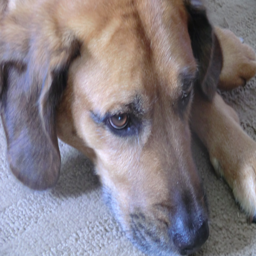

In [4]:
# download an image and read it into a NumPy array.
def download(url, max_dim=None):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = PIL.Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim,max_dim))
    return np.array(img)

def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))
    
#original_img = download(url, max_dim=500)
original_img = np.array(PIL.Image.open(r'C:/Users/Tim/Downloads/CIMG1371.jpg').resize((256,256)))
show(original_img)

In [5]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [6]:
names = ['mixed5', 'mixed7']
layers = [base_model.get_layer(name).output for name in names]

dream_model = tf.keras.models.Model(inputs=base_model.input, outputs=layers)

"The loss is the sum of the activations in the chosen layers. The loss is normalized at each layer so the contribution from larger layers does not outweigh smaller layers. Normally, loss is a quantity you wish to minimize via gradient descent. In DeepDream, you will maximize this loss via gradient ascent."

In [7]:
def calc_loss(img, model):
    img_batch = tf.expand_dims(img, axis=0) # Converts the image into a batch of size 1
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]
    
    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)
    return tf.reduce_sum(losses)

In [8]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model
    
    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None,None,3],dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32)
        )
    )
    
    def __call__(self, img, steps, step_size):
        print('Tracing')
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                tape.watch(img)
                loss = calc_loss(img, self.model)
            
            gradients = tape.gradient(loss,img)
            gradients /= tf.math.reduce_std(gradients) + 1e-8
            
            img = img + gradients*step_size
            img = tf.clip_by_value(img,-1,1)
        return loss, img

In [9]:
deepdream = DeepDream(dream_model)

In [10]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        if steps_remaining>100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps
        loss,img = deepdream(img, run_steps, tf.constant(step_size))
        display.clear_output(wait=True)
        show(deprocess(img))
        print('Step {}, loss {}'.format(step,loss))
        
    result = deprocess(img)
    display.clear_output(wait=True)
    show(result)

    return result

In [ ]:
dream_img = run_deep_dream_simple(img=original_img, steps=100, step_size=0.01)

Tracing


One issue here is that the patterns seem to all be happening at the same granularity. Not only that, the image is kind of low resolution.

"One approach that addresses all these problems is applying gradient ascent at different scales. This will allow patterns generated at smaller scales to be incorporated into patterns at higher scales and filled in with additional detail."

"To do this, you can perform the previous gradient ascent approach, then increase the size of the image (which is referred to as an octave), and repeat this process for multiple octaves."

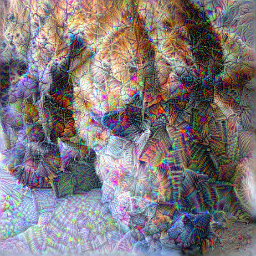

155.48432159423828

In [12]:
import time
start = time.time()

OCTAVE_SCALE = 1.3

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 4):
    new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)
    img = tf.image.resize(img, new_shape).numpy()
    img = run_deep_dream_simple(img=img, steps=50, step_size=0.02)
display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end - start

In [13]:
PIL.Image.fromarray(np.array(img)).save('boomer5_7.jpg')

In [62]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(10, 3, activation='relu', input_shape=(None,None,1)),
    tf.keras.layers.Lambda(tf.nn.local_response_normalization),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [60]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((-1,28,28,1))/255.
x_test = x_test.reshape((-1,28,28,1))/255.

In [63]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_382 (Conv2D)          (None, None, None, 10)    100       
_________________________________________________________________
lambda_3 (Lambda)            (None, None, None, 10)    0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
Total params: 210
Trainable params: 210
Non-trainable params: 0
_________________________________________________________________


In [64]:
model.fit(x_train, y_train, epochs=1)

1875/1875 [==============================] - 25s 13ms/step - loss: 2.2434 - accuracy: 0.2037
